# Const. $B$-field model demo

This notebook demonstrates the python code for the SSC model and fit of the constant $B$ field model for the Crab nebula based on Meyer et al. (2010). 

In [1]:
import sys
sys.path.append("/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/")

In [2]:
from crabmeyerpy.ssc import CrabSSC, kpc2cm
from crabmeyerpy.electrondensity import nel_crab
from crabmeyerpy.photonfields import black_body
from crabmeyerpy.data import CrabData
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

Best-fit parameters from Meyer et al. 2010 (https://arxiv.org/pdf/1008.4524.pdf)

In [5]:
config = {
    # electron spectrum parameters
    "params_n_el": {
        "Nradio": np.exp(120.),
        "gradio_min": np.exp(3.1),
        "gradio_max": np.exp(12.1),
        "Sradio": -1.60,
        "Nwind": np.exp(78.6),
        "gmin": np.exp(3.1),
        "gmax": np.exp(30.),
        "gwind_min": np.exp(12.96),
        "gwind_max": np.exp(22.51),
        "gwind_b": 1. / np.exp(19.5),
        "Swind": -3.23,
        "Sbreak": -0.53, 
        "sup_wind": 2.8,
    },
    # seed photon field parameters
    "params_n_seed": {
        "dust_T": 97.6,
        "dust_norm": 1.06e-13 / 8.11e-06,  # for new dust function
        "dust_extension": 1.3,
        "ic_sync": True, 
        "ic_dust": True,
        "ic_cmb": True
    }
}

B = 124e-6  # B Field in G
d = 2.  # distance to nebula in kpc

In [6]:
ssc = CrabSSC(copy.deepcopy(config), nel_crab, B=B, d=d)

Calculate the synchrotron and dust emission

In [7]:
nu = np.logspace(7.,25.,200)  # Frequency in Hz
F_nu_sync = ssc.sync(nu)
F_nu_dust = ssc.grey_body(nu)

/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.


Calculate the IC emission

In [8]:
nu_ic = np.logspace(20.,30.,100)  # Frequency in Hz
F_nu_IC = ssc.ic(nu_ic, g_steps=100, e_steps=50)

### Plot the model and data

First load the data

In [9]:
cd = CrabData("../data/crab_data.npy", d=ssc.d)

Text(0, 0.5, '$\\nu F_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}$)')

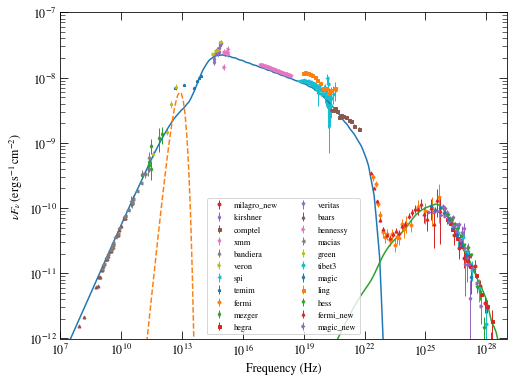

In [10]:
fig = plt.figure(figsize=(8,6))

# plot the model:
plt.loglog(nu, F_nu_sync * nu, ls='-')
plt.loglog(nu, F_nu_dust * nu, ls='--')
plt.loglog(nu_ic, F_nu_IC * nu_ic, ls='-')

# plot the data:
marker = ['o', 'd', 's', 'v', '^', '>', '<', '*']
for i, k in enumerate(cd.data.keys()):
    x, y, dy = cd.get_data_set(k, log=False, yunit='flux')
    plt.errorbar(x, y, yerr=dy,
                 ls='none', label=k, 
                 ms=3, marker=marker[i % len(marker)],
                 elinewidth=1
                )
plt.legend(loc=0, fontsize='small', ncol=2)
    
plt.gca().set_ylim(1e-12,1e-7)
plt.gca().set_xlim(1e7,1e29)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

## Perform a fit to the synchrotron data

In [11]:
from crabmeyerpy.fit import FitCrab

In [12]:
ssc = CrabSSC(copy.deepcopy(config), nel_crab, B=B, d=d)

In [13]:
fit = FitCrab(ssc, cd, fit_sync=True, dsys=0.)

Set the assumed systematic uncertainty as a fraction of the flux:

In [14]:
fit.dsys = 0.05

Generate a dictionary with starting values, parameter bounds, fixed parameters, and whether parameters are fitted in log space.

In [15]:
kwargs = fit.init_values_crab_meyer()
print (kwargs.keys())

dict_keys(['pinit', 'islog', 'fix', 'limits'])


In [16]:
print (fit.ssc.params_n_el)

{'Nradio': 1.3041808783936323e+52, 'gradio_min': 22.197951281441636, 'gradio_max': 179871.86225375102, 'Sradio': -1.6, 'Nwind': 1.3663006583383364e+34, 'gmin': 22.197951281441636, 'gmax': 10686474581524.463, 'gwind_min': 425066.114781728, 'gwind_max': 5969923797.311346, 'gwind_b': 3.3982678194950715e-09, 'Swind': -3.23, 'Sbreak': -0.53, 'sup_wind': 2.8}


Set the minimum and maximum frequencies and exclude data sets

In [17]:
nu_min = 1e9
nu_max = 1e23
exclude = ['fermi', 'ling']   # exclude old fermi data and do not use old X-ray data

In [18]:
logging.basicConfig(
                    #level=logging.DEBUG
                    level=logging.INFO
                    #filename='',filemode='w'
                   )

Plot the initial guess

948.8174937245581


/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.


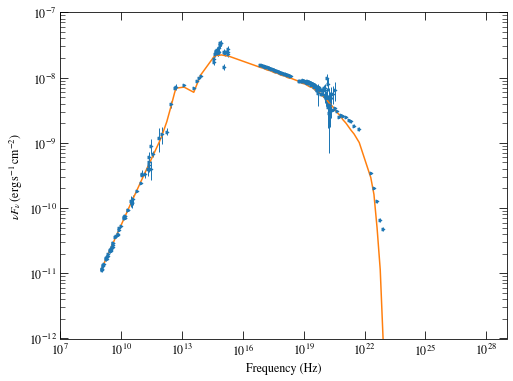

In [19]:
fig = plt.figure(figsize=(8,6))

x, y, dy = cd.build_data_set_for_fitting(exclude=exclude, nu_min=nu_min, nu_max=nu_max)

plt.errorbar(x, y, yerr=dy,
             ls='none',
             ms=3, marker=marker[i % len(marker)],
             elinewidth=1
            )
y_theo = ssc.sync(x) + ssc.grey_body(x)

plt.loglog(x, y_theo * x)

plt.gca().set_ylim(1e-12,1e-7)
plt.gca().set_xlim(1e7,1e29)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

# print the initial chi2:
print (np.sum(((y_theo * x - y)**2. / np.sqrt(dy**2. + (fit.dsys * y)**2.)**2.)))

Perform the fit

In [20]:
kwargs['max_tol_increase'] = 1e7   # increase tolerance up to this factor if fit fails
kwargs['ncall'] = int(1e4)   # number of max function calls.
kwargs['tol'] = 1e0

In [21]:
fit.fit(nu_min, nu_max, fit_sync=True, minos=0., exclude=exclude, **kwargs)

INFO:root:dict_keys(['dust_T', 'dust_norm', 'dust_extension', 'Nradio', 'gradio_min', 'gradio_max', 'Sradio', 'Nwind', 'gmin', 'gmax', 'gwind_min', 'gwind_max', 'gwind_b', 'Swind', 'Sbreak', 'sup_wind', 'B'])
INFO:root:[97.6, -7.883714988946386, 1.3, 52.11533782839022, 1.3463128939000808, 5.254963231029347, -1.6, 34.135546277595594, 1.3463128939000808, 13.028834457097554, 5.628456485466144, 9.7759687876422, -8.468742397113411, -3.23, -0.53, 2.8, 0.000124]
/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.
INFO:root:948.8174937244712
/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/ssc.py:199: RuntimeWarning: invalid value encountered in greater
  m = (log(x) > self.__start) & (log(x) < self.__end)
/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/ssc.py:199: RuntimeWarning: invalid value encountered in less
  m = (log(x) > self._

Plot the final fit

333.79115925974304
1.4835162633766357


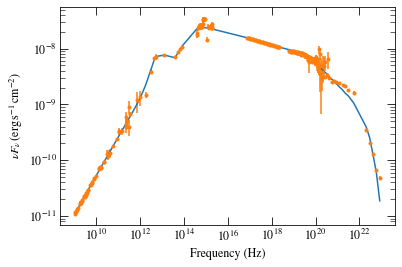

In [22]:
plt.loglog(fit.x, fit.y_theo)
plt.errorbar(fit.x, fit.y, yerr=fit.dy, ls = 'None', marker='o', ms=3.)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

# print the final chi2 / dof:
print (fit.m.fval)
print (fit.m.fval / (fit.x.size - fit.n_pars))

### Perform a fit to the IC part only, only varying the B field

Use the best fit parameters of the synchrotron fit and vary the magnetic field. 
This is essentially what was done in Meyer et al. (2010) and in the subsequent MAGIC paper.
First, write out the best fit of the previous fit.

In [23]:
best_fit = fit.write_best_fit()
print (best_fit)

{'params_n_el': {'Nradio': 1.294571746531183e+52, 'gradio_min': 37.8496238956413, 'gradio_max': 194727.4973459604, 'Sradio': -1.6026453519504011, 'Nwind': 1.9849922202594766e+34, 'gmin': 22.19795128144164, 'gmax': 10686474581524.45, 'gwind_min': 437605.1849557422, 'gwind_max': 5972053855.542643, 'gwind_b': 3.669080130149059e-09, 'Swind': -3.2143591327893954, 'Sbreak': -0.573604201304444, 'sup_wind': 3.554709120134853}, 'params_n_seed': {'dust_T': 94.27444536759222, 'dust_norm': 1.414618026267864e-08, 'dust_extension': 1.3, 'ic_sync': True, 'ic_cmb': True, 'ic_dust': True}, 'B': 0.000124, 'd': 2.0}


In [24]:
ssc2 = CrabSSC(best_fit, n_el=nel_crab, B=best_fit['B'], d=best_fit['d'])

In [25]:
fit_ic = FitCrab(ssc2, cd, fit_sync=False, dsys=0.)

Set the systematic uncertainty:

In [26]:
fit_ic.dsys=0.05

In [27]:
kwargs_ic = fit_ic.init_values_crab_meyer()

Fix all parameters but the magnetic field

In [28]:
for k in kwargs_ic['fix'].keys():
    kwargs_ic['fix'][k] = True
kwargs_ic['fix']['B'] = False

exclude all data sets for IC component except MAGIC and Fermi data of 2015 paper

In [29]:
exclude_ic = []
for k in cd.data.keys():
    if not k in ['fermi_new', 'magic_new']:
        exclude_ic.append(k)

nu_min = 1e23
nu_max = 1e30

Plot the initial guess

/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.


239.39988290627917


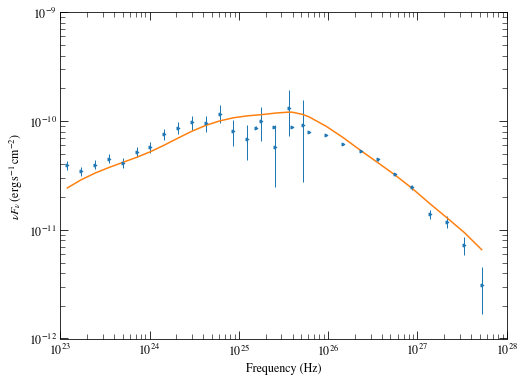

In [30]:
fig = plt.figure(figsize=(8,6))

x, y, dy = cd.build_data_set_for_fitting(exclude=exclude_ic, nu_min=nu_min, nu_max=nu_max)

plt.errorbar(x, y, yerr=dy,
             ls='none',
             ms=3, marker=marker[i % len(marker)],
             elinewidth=1
            )
y_theo = ssc.ic(x)

plt.loglog(x, y_theo * x)

plt.gca().set_ylim(1e-12,1e-9)
plt.gca().set_xlim(1e23,1e28)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

# print the initial chi2:
print (np.sum(((y_theo * x - y)**2. / np.sqrt(dy**2. + (fit_ic.dsys * y)**2.)**2.)))

In [31]:
kwargs_ic['max_tol_increase'] = 1e7   # increase tolerance up to this factor if fit fails
kwargs_ic['ncall'] = int(1e3)   # number of max function calls.
kwargs_ic['tol'] = 1e-1

In [32]:
fit_ic.fit(nu_min, nu_max, fit_sync=False, minos=0., exclude=exclude_ic, **kwargs_ic)

INFO:root:dict_keys(['dust_T', 'dust_norm', 'dust_extension', 'Nradio', 'gradio_min', 'gradio_max', 'Sradio', 'Nwind', 'gmin', 'gmax', 'gwind_min', 'gwind_max', 'gwind_b', 'Swind', 'Sbreak', 'sup_wind', 'B'])
INFO:root:[94.27444536759222, -7.84936081206809, 1.3, 52.11212612449599, 1.5780615683576467, 5.289427282297744, -1.6026453519504011, 34.297758808980745, 1.3463128939000808, 13.028834457097554, 5.6410824590848065, 9.776123715506358, -8.43544280345213, -3.2143591327893954, -0.573604201304444, 3.554709120134853, 0.000124]
/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.
INFO:root:259.62817151661784
INFO:root:fit took: 8.16589617729187s
INFO:root:best fit dust_T: 9.42744e+01 +/- nan
INFO:root:best fit dust_norm: -7.84936e+00 +/- nan
INFO:root:best fit dust_extension: 1.30000e+00 +/- nan
INFO:root:best fit Nradio: 5.21121e+01 +/- nan
INFO:root:best fit gra

/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.


249.74342831131685
7.8044821347286515


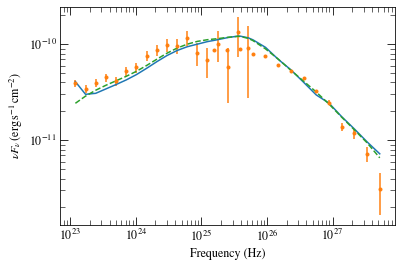

In [33]:
plt.loglog(fit_ic.x, fit_ic.y_theo)
plt.errorbar(fit_ic.x, fit_ic.y, yerr=fit_ic.dy, ls = 'None', marker='o', ms=3.)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

#plt.loglog(nu, fit_ic.ssc.sync(nu) * nu, ls='-')
#plt.loglog(nu, fit.ssc.sync(nu) * nu, ls='--')
plt.loglog(fit_ic.x, fit.ssc.ic(fit_ic.x) * fit_ic.x, ls='--')
# print the final chi2 / dof:
print (fit_ic.m.fval)
print (fit_ic.m.fval / (fit_ic.x.size - fit_ic.n_pars))

## Fit synchrotron and IC part simultaneously


In [34]:
ssc3 = CrabSSC(best_fit, n_el=nel_crab, B=best_fit['B'], d=best_fit['d'])

In [35]:
fit_all = FitCrab(ssc3, cd, fit_sync=False, fit_ic=False, dsys=0.05)

In [36]:
kwargs_all = fit_ic.init_values_crab_meyer()

In [37]:
kwargs_all['fix']['B'] = False

In [38]:
nu_min = 1e9
nu_max = 1e30
# exclude old fermi and magic data and do not use old X-ray data
# for high energies use only new magic data as in 2015 paper
exclude_all = ['fermi', 'ling', 'magic', 'hess', 'milagro', 'tibet3', 'hegra', 'veritas', 'milagro_new']

Plot the initial guess

/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.


569.1872079299917


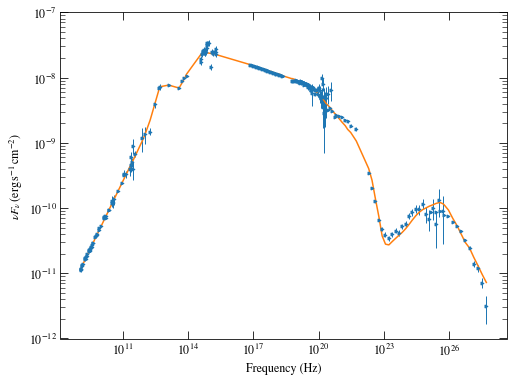

In [39]:
fig = plt.figure(figsize=(8,6))

x, y, dy = cd.build_data_set_for_fitting(exclude=exclude_all, nu_min=nu_min, nu_max=nu_max)

plt.errorbar(x, y, yerr=dy,
             ls='none',
             ms=3, marker=marker[i % len(marker)],
             elinewidth=1
            )

m = x < 1e22
y_theo = np.zeros_like(x)
y_theo[m] = (ssc3.sync(x[m], g_steps=50) + ssc3.grey_body(x[m])) * x[m]
y_theo[~m] = (ssc3.ic(x[~m], g_steps=100, e_steps=50) + ssc3.sync(x[~m], g_steps=50)) * x[~m]

plt.loglog(x, y_theo)

plt.gca().set_ylim(1e-12,1e-7)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

# print the initial chi2:
print (np.sum(((y_theo - y)**2. / np.sqrt(dy**2. + (fit_ic.dsys * y)**2.)**2.)))

In [40]:
kwargs_all['max_tol_increase'] = 1e7   # increase tolerance up to this factor if fit fails
kwargs_all['ncall'] = int(1e4)   # number of max function calls.
kwargs_all['tol'] = 1e0

In [41]:
fit_all.fit(nu_min, nu_max, fit_sync=False, fit_ic=False, minos=0., exclude=exclude_all, **kwargs_all)

INFO:root:dict_keys(['dust_T', 'dust_norm', 'dust_extension', 'Nradio', 'gradio_min', 'gradio_max', 'Sradio', 'Nwind', 'gmin', 'gmax', 'gwind_min', 'gwind_max', 'gwind_b', 'Swind', 'Sbreak', 'sup_wind', 'B'])
INFO:root:[94.27444536759222, -7.84936081206809, 1.3, 52.11212612449599, 1.5780615683576467, 5.289427282297744, -1.6026453519504011, 34.297758808980745, 1.3463128939000808, 13.028834457097554, 5.6410824590848065, 9.776123715506358, -8.43544280345213, -3.2143591327893954, -0.573604201304444, 3.554709120134853, 0.00015504709633004028]
/Users/manuelmeyer/Dropbox/Projects/SSC/crabmeyerpy/crabmeyerpy/photonfields.py:24: RuntimeWarning: overflow encountered in exp
  result[kx >= 1e-10] = np.exp(kx[kx >= 1e-10]) - 1.
INFO:root:18792.96001684905
INFO:root:New tolerance : 2.8039466945700307e+35
INFO:root:fit took: 324.03737592697144s
INFO:root:best fit dust_T: 1.02090e+02 +/- 1.51070e-04
INFO:root:best fit dust_norm: -7.96261e+00 +/- 2.61066e-06
INFO:root:best fit dust_extension: 1.30000e+

487.0243494219667
1.8950363790738003


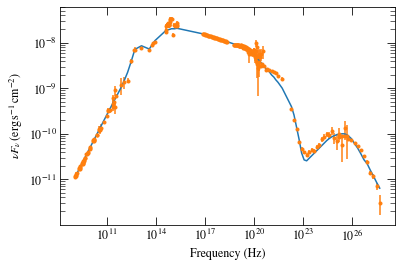

In [42]:
plt.loglog(fit_all.x, fit_all.y_theo)
plt.errorbar(fit_all.x, fit_all.y, yerr=fit_all.dy, ls = 'None', marker='o', ms=3.)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

# print the final chi2 / dof:
print (fit_all.m.fval)
print (fit_all.m.fval / (fit_all.x.size - fit_all.n_pars))

## To Do's:

- re-implement the possibility of an energy scale between Fermi and IACT data
- implement dependence on angular separation from center. This likely entails a new SSC class, which evaluates IC and synchrotron emission at frequency $\nu$ and angular separation $\theta$. 